<a href="https://colab.research.google.com/github/ram130849/Deep_Learning_Systems_Assignments/blob/main/TensorFlow/Sushant/DLS_Assignment_4_Part4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import timeit
from tensorflow.keras.utils import to_categorical
import pickle
import random
import librosa
import librosa.display
from itertools import combinations,product
from tensorflow.keras.layers import Layer
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten
from keras.models import Model
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
0.411242604999984
GPU (s):
0.03964345899998989
GPU speedup over CPU: 10x


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train_path = '/content/drive/MyDrive/DLS_Assignments/Assignment4_Files/hw4_trs.pkl'
test_path = '/content/drive/MyDrive/DLS_Assignments/Assignment4_Files/hw4_tes.pkl'

In [97]:
tr_pickle = open(train_path,'rb')
ts_pickle = open(test_path,'rb')
x_train = pickle.load(tr_pickle)
x_test = pickle.load(ts_pickle)

In [98]:
print(x_train.shape)

(500, 16180)


In [99]:
print(x_test.shape)

(200, 22631)


### Creating Positive Samples

In [100]:
positive_pairs_index = random.sample(list(combinations(range(10),2)),45)

In [101]:
x_train[0][0]

4.1278403e-05

In [102]:
x_train_stft = np.zeros(shape=(500,45,513))
for i in range(x_train.shape[0]):
    x = x_train[i,:]
    X_complex = librosa.stft(x, n_fft=1024, hop_length=512)
    X = np.abs(X_complex).T
    x_train_stft[i,:,:] = np.pad(X,((0,13),(0,0)), 'constant')
print(x_train_stft.shape)

(500, 45, 513)


In [103]:
y_train = np.zeros((500,1))
index=0
for i in range(0,50):
    for j in range(0,10):
        y_train[index]=i
        index+=1
print(y_train.shape)

(500, 1)


In [104]:
x_train_stft[0].shape

(45, 513)

In [105]:
x_test_stft = np.zeros(shape=(200,45,513))
for i in range(x_test.shape[0]):
    x = x_test[i,:]
    X_complex = librosa.stft(x, n_fft=1024, hop_length=512)
    X = np.abs(X_complex).T
    x_test_stft[i,:,:] = X
print(x_test_stft.shape)

(200, 45, 513)


In [106]:
y_test = np.zeros((200,1))
idx=0
for i in range(0,20):
    for j in range(0,10):
        y_test[idx]=i
        idx+=1
print(y_test.shape)

(200, 1)


In [107]:
y_train = np.array(y_train)
X_index = np.arange(0,len(y_train)).reshape(-1,1)

In [108]:
num_pairs = 45
unique_speaker = np.unique(y_train)

In [109]:
def positive_pair(pos_index,pairs,labels,data):
  positive_list = list(combinations(pos_index,2))
  positive_pairs = random.sample(positive_list,num_pairs)
  for pair in positive_pairs:
    inst1,inst2 = data[pair[0],:,:], data[pair[1],:,:]
    pairs = pairs + [[inst1,inst2]]
    labels = labels + [0]
  return pairs,labels

In [110]:
def add_negative_pairs(pos_index,neg_index,pairs,label,data):
  negative_list = list(product(pos_index,neg_index))
  negative_pairs = random.sample(negative_list,num_pairs)
  for pair in negative_pairs:
    inst1,inst2 = data[pair[0],:,:], data[pair[1],:,:]
    pairs = pairs + [[inst1,inst2]]
    label = label + [1]
  return pairs,label

In [111]:
pair_list = []
labels =[]
for speaker in unique_speaker:
  speaker1_index = X_index[np.where(y_train==speaker)]
  speaker2_index = X_index[np.where(y_train!=speaker)]
  pair_list,labels = positive_pair(speaker1_index,pair_list,labels,x_train_stft)
  #print(len(pair_pos))
  pair_list,labels = add_negative_pairs(speaker1_index,speaker2_index,pair_list,labels,x_train_stft)
  #pair_list.append(final_pair)
  #labels.append(final_labels)
  #print(len(final_pair_list)) 
  #print(len(final_labels))

pair_list = np.asarray(pair_list)
labels = np.asarray(labels).astype("float32")

In [112]:
y_test = np.array(y_test)
x_index = np.arange(0,len(y_test)).reshape(-1,1)
unique_speaker = np.unique(y_test)

In [113]:
test_pair_list = []
test_labels =[]
for speaker in unique_speaker:
  speaker1_index = X_index[np.where(y_test==speaker)]
  speaker2_index = X_index[np.where(y_test!=speaker)]
  test_pair_list,test_labels = positive_pair(speaker1_index,test_pair_list,test_labels,x_test_stft)
  #print(len(pair_pos))
  test_pair_list,test_labels = add_negative_pairs(speaker1_index,speaker2_index,test_pair_list,test_labels,x_test_stft)
  #pair_list.append(final_pair)
  #labels.append(final_labels)
  #print(len(final_pair_list)) 
  #print(len(final_labels))

test_pair_list = np.asarray(test_pair_list)
test_labels = np.asarray(test_labels).astype("float32")

In [114]:
pair_list.shape

(4500, 2, 45, 513)

In [115]:
len(labels)

4500

In [116]:
test_pair_list.shape

(1800, 2, 45, 513)

In [117]:
len(test_labels)

1800

In [118]:
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
  x, y = vects
  sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
  return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

In [119]:
def loss(margin):
    """
    Returns:
        'constrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) + true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
      square_pred = tf.math.square(y_pred)
      margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
      return tf.math.reduce_mean(
          (1 - y_true) * square_pred + (y_true) * margin_square
      )

    return contrastive_loss

In [120]:
input = layers.Input(shape=(45,513))
x = tf.keras.layers.GRU(513, return_sequences=True,dropout=0.2)(input),
x = tf.keras.layers.GRU(513, return_sequences=False,dropout=0.2)(x[0]),
#x = tf.keras.layers.GRU(513, return_sequences=False,dropout=0.2)(x[1]),
x = tf.keras.layers.Dense(128,activation = 'relu')(x[0]),
x = tf.keras.layers.Dense(32,activation = 'relu')(x[0])

embedding_network = tf.keras.Model(input, x)

ip1 = layers.Input((45,513))
ip2 = layers.Input((45,513))

inst_1 = embedding_network(ip1)
inst_2 = embedding_network(ip2)

x2 = tf.keras.layers.Lambda(euclidean_distance)([inst_1, inst_2])
op = tf.keras.layers.Dense(1, activation="sigmoid")(x2)
model_4 = tf.keras.Model(inputs=[ip1, ip2], outputs=op)

In [121]:
model_4.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_35 (InputLayer)          [(None, 45, 513)]    0           []                               
                                                                                                  
 input_36 (InputLayer)          [(None, 45, 513)]    0           []                               
                                                                                                  
 model_22 (Functional)          (None, 32)           3234104     ['input_35[0][0]',               
                                                                  'input_36[0][0]']               
                                                                                                  
 lambda_11 (Lambda)             (None, 1)            0           ['model_22[0][0]',        

In [122]:
model_4.compile(loss=loss(margin=1), optimizer="adam", metrics=["accuracy"])

In [123]:
history = model_4.fit(
    [pair_list[:,0], pair_list[:,1]],
    labels,
    validation_data=([test_pair_list[:,0],test_pair_list[:,1]],test_labels),
    batch_size=90,
    epochs=40
)

Epoch 1/40
50/50 [==============================] - 9s 65ms/step - loss: 0.2474 - accuracy: 0.5011 - val_loss: 0.2493 - val_accuracy: 0.4983
Epoch 2/40
50/50 [==============================] - 2s 31ms/step - loss: 0.2266 - accuracy: 0.5162 - val_loss: 0.2109 - val_accuracy: 0.5239
Epoch 3/40
50/50 [==============================] - 2s 31ms/step - loss: 0.1989 - accuracy: 0.6240 - val_loss: 0.2099 - val_accuracy: 0.6028
Epoch 4/40
50/50 [==============================] - 2s 31ms/step - loss: 0.1812 - accuracy: 0.7018 - val_loss: 0.1981 - val_accuracy: 0.6550
Epoch 5/40
50/50 [==============================] - 2s 32ms/step - loss: 0.1678 - accuracy: 0.7613 - val_loss: 0.1880 - val_accuracy: 0.6906
Epoch 6/40
50/50 [==============================] - 2s 31ms/step - loss: 0.1556 - accuracy: 0.8064 - val_loss: 0.1845 - val_accuracy: 0.6906
Epoch 7/40
50/50 [==============================] - 2s 31ms/step - loss: 0.1488 - accuracy: 0.8353 - val_loss: 0.1871 - val_accuracy: 0.7106
Epoch 8/40
50

In [59]:
history1 = model_4.evaluate([test_pair_list[:,0],test_pair_list[:,1]],test_labels)

57/57 [==============================] - 2s 11ms/step - loss: 0.1953 - accuracy: 0.7256


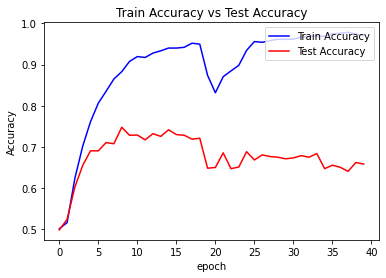

In [126]:
plt.plot(history.history["accuracy"],color='blue')
plt.plot(history.history["val_accuracy"],color='red')
plt.legend(["Train Accuracy", "Test Accuracy"], loc="upper right")
plt.title("Train Accuracy vs Test Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("epoch")
plt.show()